In [64]:
import matplotlib.pyplot as plt
from math import exp
from scipy import stats
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import numpy as np
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)

## Step 1: Read in hold out data, scalers, and best model

In [66]:
holdout = pd.read_csv('CSVs/kc_house_data_test_features.csv', index_col=0)

In [67]:
import pickle

read_pickle = open('pickled_files/selected_columns.pickle', 'rb')
selected_columns = pickle.load(read_pickle)
read_pickle.close()

read_pickle = open('pickled_files/model.pickle', 'rb')
model = pickle.load(read_pickle)
read_pickle.close()



## Step 2: Feature Engineering for holdout set

Remember we have to perform the same transformations on our holdout data (feature engineering, extreme values, and scaling) that we performed on the original data.

In [68]:
def date_time(df):
    df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
    df['date'] = df['date'].apply(lambda x: x.value)
    
date_time(holdout)

In [69]:
holdout['price'] = 0

In [70]:
features = list(holdout.columns)
len(features)

21

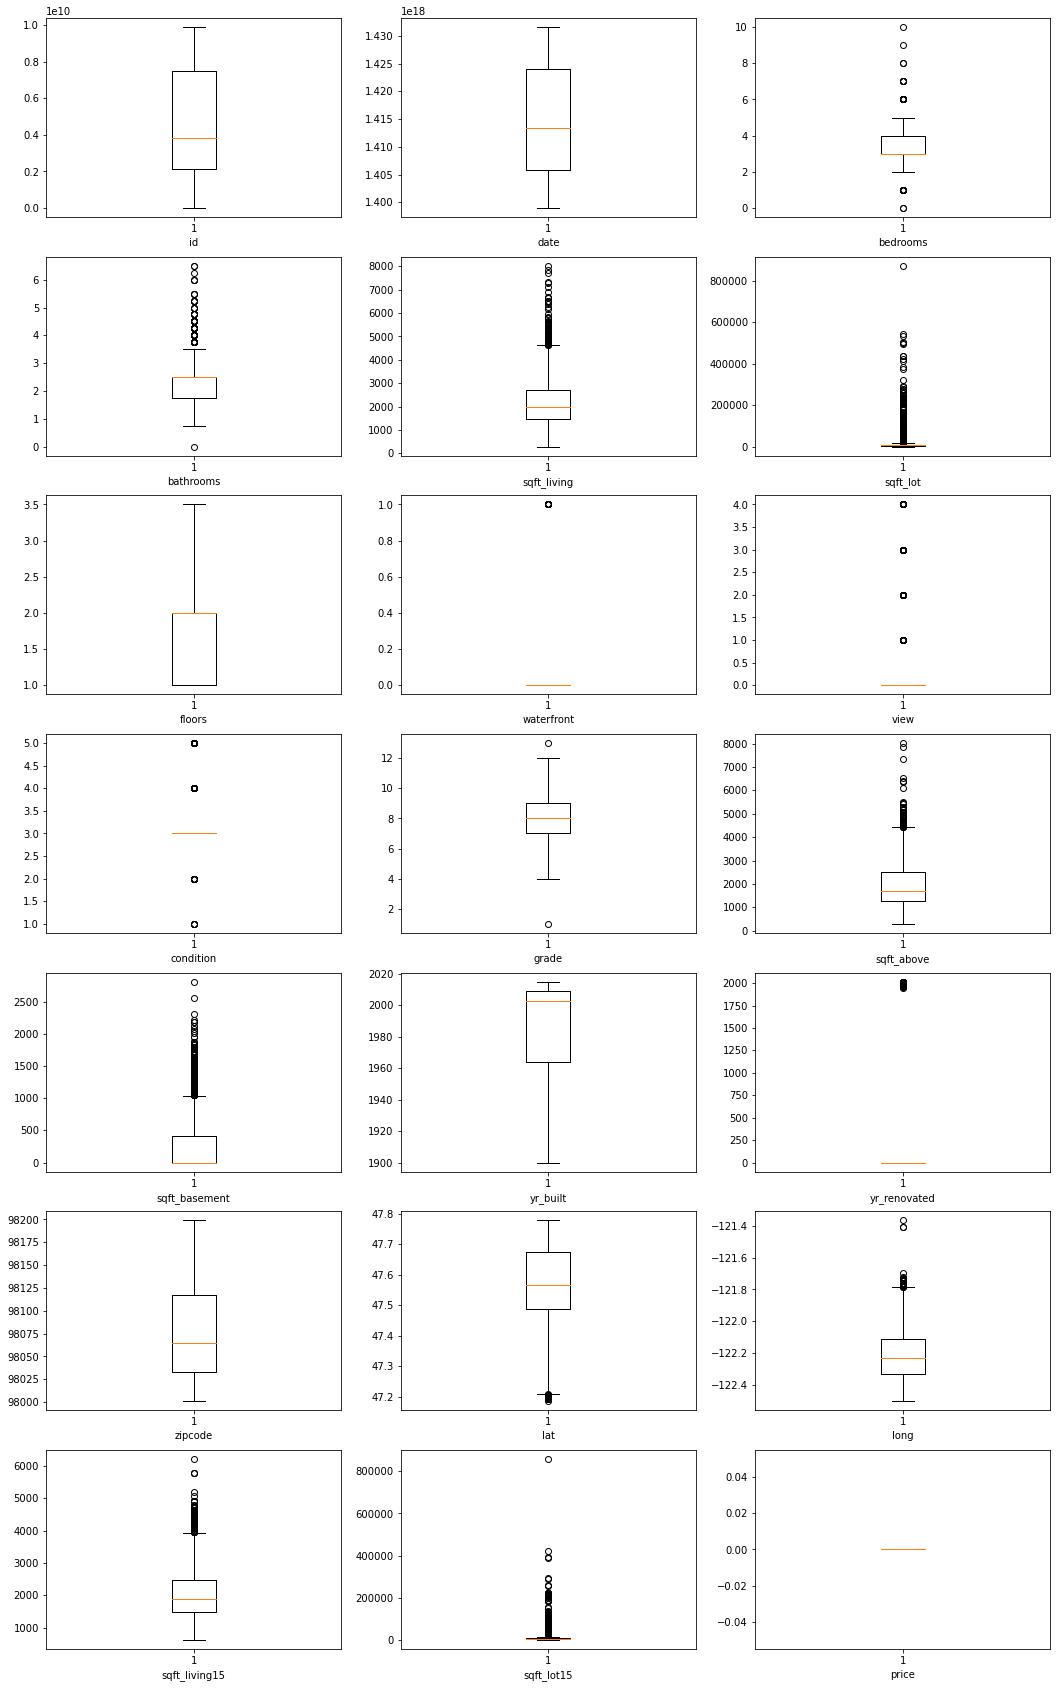

In [71]:
f, axs = plt.subplots(7, 3, sharey=False, figsize = (18,30))
count = 0
while count < 21:
    for i in (0, 1, 2, 3, 4, 5, 6):
        for x in (0, 1, 2):
            axs[i, x].boxplot(holdout.iloc[:, count])
            axs[i, x].set_xlabel(features[count])
            count += 1

In [72]:
bdrm_per_sf = holdout['bedrooms'].mean() / holdout['sqft_living'].mean()

x = holdout['bedrooms']
y = holdout['sqft_living']

condlist = [x > 15, x<= 15]
choicelist = [round(y * bdrm_per_sf, 0), x]

holdout['bedrooms'] = np.select(condlist, choicelist)

In [73]:
holdout['second_sale'] = [1 if x == True else 0 for x in holdout.duplicated(subset='id', keep='last')]

In [74]:
read_pickle = open('pickled_files/zips_by_price.pickle', 'rb')
zips_by_price = pickle.load(read_pickle)
read_pickle.close()

holdout['zips_by_price'] = holdout['zipcode']
zips_by_mean_price_dict = dict(zip(zips_by_price['zipcode'], zips_by_price['index']))
holdout['zips_by_price'].replace(zips_by_mean_price_dict, inplace = True)

holdout['log_zipbyprice'] = np.log(holdout['zips_by_price'])
holdout['zips_by_price_exp'] = np.exp(0.0198 * holdout['zips_by_price'])

In [75]:
#not useful
holdout.drop(columns = 'log_zipbyprice', inplace = True)

In [76]:
holdout['distance_from_space_needle'] = np.sqrt((47.6205 - holdout['lat']) ** 2 + (122.3493 - holdout['long']) ** 2)

In [78]:
df_price = pd.read_csv('CSVs/KC_zips_price.csv')
zips_by_mean_price_dict_ext = dict(zip(df_price['Zip'], df_price['Rank']))
holdout['zips_by_price_ext'] = holdout['zipcode']
holdout['zips_by_price_ext'].replace(zips_by_mean_price_dict_ext, inplace = True)

x = holdout['zips_by_price_ext']
condlist = [x > 50, x <51]
choicelist = [51, x]
holdout['zips_by_price_ext_tidy'] = np.select(condlist, choicelist)

holdout['zips_by_price_ext_tidy_power'] = holdout['zips_by_price_ext_tidy'] ** -.316

In [79]:
#not useful
holdout.drop(columns = 'zips_by_price_ext', inplace = True)

In [81]:
zip_indexing_NICHE = pd.read_csv("CSVs/zip_indexing_NICHE.csv")
zips_by_NICHErank_dict = dict(zip(zip_indexing_NICHE['Zip'], zip_indexing_NICHE['NICHE ranking']))

holdout['zips_by_liv_qual'] = holdout['zipcode']
holdout['zips_by_liv_qual'].replace(zips_by_NICHErank_dict, inplace = True)
holdout['zips_by_liv_qual'].replace({98005: 13, 98022: 51, 26:1}, inplace = True)

holdout['mod_zips_by_liv_qual'] = np.exp(-0.015 * holdout['zips_by_liv_qual'])

In [82]:
holdout['sale_year'] = pd.DatetimeIndex(holdout['date']).year

x = holdout['yr_renovated']
y = holdout['sale_year']
z = holdout['yr_built']
condlist = [x == 0, x != 0]
choicelist = [y-z, y-x]
holdout['years_since_reno'] = np.select(condlist, choicelist)

x = holdout['yr_renovated']
condlist = [x >= 2012, x < 2012]
choicelist = [1, 0]
holdout['recent_reno'] = np.select(condlist, choicelist)

In [83]:
x = holdout['sqft_lot']

condlist = [x >= 10000, x < 10000]
choicelist = [x - np.sqrt(x), x]
holdout['sqft_lot'] = np.select(condlist, choicelist)

In [84]:
#These turned out to not be useful

#holdout['sqft_living_2'] = holdout['sqft_living'] ** 2
#holdout['sqft_living_3'] = holdout['sqft_living'] ** 3 
#holdout['sqft_living_4'] = holdout['sqft_living'] ** 4
#holdout['sqft_living_5'] = holdout['sqft_living'] ** 5
#holdout['sqft_living_6'] = holdout['sqft_living'] ** 6

In [85]:
x = holdout['sqft_living']

condlist = [x >= 6000, x < 6000]
choicelist = [x-x**(0.5), x]
holdout['sqft_living'] = np.select(condlist, choicelist)

In [86]:
holdout['living_compared_to_15'] = (holdout['sqft_living15'] - holdout['sqft_living']) ** 2
holdout['lot_compared_to_15'] = holdout['sqft_lot15'] - holdout['sqft_lot']


In [87]:
holdout['grade_cats'] = holdout['grade']
holdout['grade_cats'].replace({2:1, 3:1, 4:1,11:13,12:13}, inplace = True)


In [88]:
holdout['zip_rank_variance'] = abs(holdout['zips_by_price'] - holdout['zips_by_liv_qual'])

In [89]:
holdout = holdout.join(pd.get_dummies(holdout['zipcode'], prefix = 'x', drop_first = True))

In [90]:
holdout['bdrms_squared'] = holdout['bedrooms'] ** 2

In [91]:
holdout['waterfront_long'] = (holdout['waterfront'] + 125) * (holdout ['long'])

In [92]:
read_pickle = open('pickled_files/features_to_poly2.pickle', 'rb')
features_to_poly2 = pickle.load(read_pickle)
read_pickle.close()

holdout = holdout[features_to_poly2]

In [93]:
from sklearn.preprocessing import PolynomialFeatures

poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(holdout)
poly2_columns = poly_2.get_feature_names(holdout.columns)
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)

## Step 3: Predict the holdout set

In [94]:
selected_columns

Index(['sqft_living', 'grade_cats', 'grade', 'sqft_above', 'zips_by_price_exp',
       'sqft_living15', 'zips_by_price_ext_tidy_power', 'zips_by_price',
       'zips_by_price_ext_tidy', 'bathrooms',
       ...
       'zips_by_price_ext_tidy zipcode', 'bathrooms^2',
       'bathrooms mod_zips_by_liv_qual', 'bathrooms bedrooms', 'bathrooms lat',
       'bathrooms waterfront_long', 'bathrooms yr_built', 'bathrooms zipcode',
       'bathrooms condition', 'mod_zips_by_liv_qual bedrooms'],
      dtype='object', length=140)

In [95]:
features = df_poly2[selected_columns]

In [96]:
y_pred = model.predict(features)

In [97]:
len(y_pred)

4322

In [104]:
final_predictions = pd.DataFrame(y_pred, columns = ['Price'])

## Step 4: Export your predictions

In [106]:
final_predictions.to_csv('housing_preds_clare_dunne.csv')